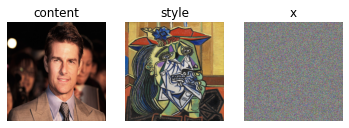

In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from PIL import Image


base_model = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
base_model.trainable = False
output = []


for i in range(1,6):
    name = "block" + str(i) + "_conv1"
    o = base_model.get_layer(name).output
    output.append(o)
    
models = tf.keras.models.Model(inputs=base_model.input, outputs=output)

input_size = 600
x = np.random.uniform(0,255,(input_size,input_size,3))#white noise
x = tf.Variable(x/255)

dir_content = "D:\\ML\\artistic\\content\\content.jpg"#Your dir
dir_style = "D:\\ML\\artistic\\style\\style.jpg"#Your dir
p = Image.open(dir_content)
a = Image.open(dir_style)
p = p.resize((input_size,input_size))
a = a.resize((input_size,input_size))


p = np.asarray(p)/255
a = np.asarray(a)/255

plt.subplot(1,3,1)
plt.imshow(p)
plt.title("content")
plt.axis('off')

plt.subplot(1,3,2)
plt.imshow(a)
plt.title("style")
plt.axis('off')

plt.subplot(1,3,3)
plt.imshow(x.numpy())
plt.title("x")
plt.axis('off')

plt.show()



In [2]:
base_model.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

In [3]:
def get_loss_content(x,p):
    f = models(tf.convert_to_tensor([x,p]))[3]
    assert f.shape[0]==2 and len(f.shape)==4, print("Shape error")
    loss_content = tf.reduce_sum(tf.square(f[0]-f[1]))
    return loss_content

#content loss

In [4]:
def get_loss_style(x,a):
    F_list = []
    for f in models(tf.convert_to_tensor([x,a])):
        f = tf.transpose(f, (0,3,1,2))
        f = tf.reshape(f, (f.shape[0], f.shape[1],-1))
        F_list.append(f)
        

    loss_style = tf.Variable(0, dtype=tf.float32)
    for f0, f1 in F_list:
    
        g_f0 = tf.matmul(f0, tf.transpose(f0))
    
        
    
        g_f1 = tf.matmul(f1, tf.transpose(f1))
        e = tf.reduce_sum(tf.square(g_f0-g_f1))
        loss_style = tf.add(loss_style,e*0.2)
    return loss_style


In [5]:
epoch_num=5000+1 #Stop when result is good enough
alpha = 1
beta = 1e-5

for epoch in range(epoch_num):
    with tf.GradientTape() as tape:
        X = tf.keras.applications.vgg19.preprocess_input(x*255)
        P = tf.keras.applications.vgg19.preprocess_input(p*255)
        A = tf.keras.applications.vgg19.preprocess_input(a*255)
        
        loss_content = get_loss_content(P,X)
        
        loss_style = get_loss_style(A,X)
        total_loss = tf.add(alpha*loss_content,beta*loss_style)
    grads = tape.gradient(total_loss, x)
    optimizer = tf.optimizers.Adam(learning_rate=0.0002)
    optimizer.apply_gradients(grads_and_vars = [(grads,x)])
    if epoch%50==0:
        print(epoch, "content loss:",loss_content.numpy(), "style loss:", loss_style.numpy()*1e-9, "total loss:", total_loss.numpy()*1e-13, "content/style:",loss_content.numpy()/loss_style.numpy())
        plt.imshow(x.numpy())
        plt.title(str(epoch)+"epoch")
        plt.show()

KeyboardInterrupt: 

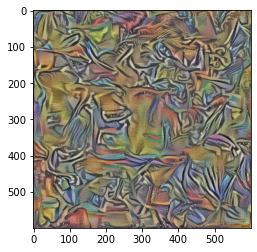

In [14]:

img = tf.nn.relu(x).numpy()#Make sure pixel value > 0
img[img>1] = 1 # Make sure pixel value <= 1

plt.imshow(img)

plt.imsave("D:\\ML\\artistic\\tom picaso1.jpg", img)